In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 37.9 MB/s eta 0:00:00


In [2]:
import time
from pathlib import Path
from tqdm import tqdm

import cv2
import torch
import numpy as np
import pandas as pd
from ultralytics import YOLO
from torchvision.models.detection import ssd300_vgg16, SSD300_VGG16_Weights, fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
import torchvision.transforms.functional as F

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
from google.colab import files
import os
import shutil

In [4]:
uploaded = files.upload()

Saving changeable_conditions.mp4 to changeable_conditions.mp4
Saving clear_weather.mp4 to clear_weather.mp4
Saving dark_video.mp4 to dark_video.mp4
Saving poor_weather.mp4 to poor_weather.mp4


In [5]:
# Создаём папку data/videos, если её ещё нет
target_dir = "data/videos"
os.makedirs(target_dir, exist_ok=True)

# Перемещаем загруженные файлы в data/videos/
for filename in uploaded.keys():
    src_path = filename              # /content/filename
    dst_path = os.path.join(target_dir, filename)
    shutil.move(src_path, dst_path)

In [8]:
CHANGEABLE_CONDITIONS_VIDEO_PATH = Path("/content/data/videos/changeable_conditions.mp4")
CLEAR_WHEATHER_VIDEO_PATH = Path("/content/data/videos/clear_weather.mp4")
DARK_VIDEO_PATH = Path("/content/data/videos/dark_video.mp4")
POOR_WEATHER_VIDEO_PATH = Path("/content/data/videos/poor_weather.mp4")

In [7]:
# Порог для уверенности и IoU (общие для всех)
CONF_TH = 0.3
IOU_TH = 0.45

# Классы "person" для разных моделей (COCO)
YOLO_PERSON_ID = 0
SSD_PERSON_LABEL = 1
FASTER_PERSON_LABEL = 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [9]:
# YOLOv8 (ultralytics)
yolo_model = YOLO("yolov8n.pt")

# SSD300
ssd_weights = SSD300_VGG16_Weights.DEFAULT
ssd_model = ssd300_vgg16(weights=ssd_weights).to(device)
ssd_model.eval()

# Faster R-CNN
fasterrcnn_weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
fasterrcnn_model = fasterrcnn_resnet50_fpn(weights=fasterrcnn_weights).to(device)
fasterrcnn_model.eval()

SSD_CATEGORIES = ssd_weights.meta["categories"]
FASTER_CATEGORIES = fasterrcnn_weights.meta["categories"]

Downloading: "https://download.pytorch.org/models/ssd300_vgg16_coco-b556d3b4.pth" to /root/.cache/torch/hub/checkpoints/ssd300_vgg16_coco-b556d3b4.pth


100%|██████████| 136M/136M [00:00<00:00, 183MB/s]


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


100%|██████████| 160M/160M [00:00<00:00, 172MB/s]


In [10]:
def make_video_summary(
    *,
    model_name: str,
    video_path,
    total_frames: int,
    processed_frames: int,
    sample_every: int,
    max_frames,
    avg_fps: float,
    total_person_dets: int,
    avg_persons_per_frame: float,
    max_persons_on_frame: int,
    avg_confidence: float,
    conf: float,
    iou: float | None = None,
) -> dict:
    """
    Возвращает словарь с метриками по видео в едином формате
    для YOLO, SSD и Faster R-CNN.
    """
    return {
        "model_name": model_name,
        "video_name": Path(video_path).name,

        "frames_total": total_frames,
        "frames_processed": processed_frames,
        "sample_every": sample_every,
        "max_frames": max_frames,

        "avg_fps": avg_fps,
        "total_person_dets": int(total_person_dets),
        "avg_persons_per_frame": avg_persons_per_frame,
        "max_persons_on_frame": int(max_persons_on_frame),
        "avg_confidence": avg_confidence,
        "conf_th": conf,

        "iou_th": iou, # для YOLO — число, для SSD/Faster — None
    }


In [11]:
def evaluate_video_yolo_simple(
    video_path: Path,
    model,
    model_name: str = "yolov8n",
    conf: float = CONF_TH,
    iou: float = IOU_TH,
    person_id: int = YOLO_PERSON_ID,
    sample_every: int = 1,
    max_frames: int | None = None,
    output_path: Path | None = None,
):
    """
    Прогоняет видео через YOLOv8, опционально сохраняет размеченное видео
    и возвращает: (output_path, summary_dict) в формате make_video_summary().
    Метрики считаются только по людям (person_id), но на видео рисуются все классы.
    """
    video_path = Path(video_path)
    cap = cv2.VideoCapture(str(video_path))
    if not cap.isOpened():
        raise RuntimeError(f"Не удалось открыть видео: {video_path}")

    width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    native_fps = cap.get(cv2.CAP_PROP_FPS) or 0.0

    out = None
    if output_path is not None:
        output_path = Path(output_path)
        output_path.parent.mkdir(parents=True, exist_ok=True)
        fourcc = cv2.VideoWriter_fourcc(*"mp4v")
        fps_out = native_fps if native_fps > 0 else 25.0
        out = cv2.VideoWriter(str(output_path), fourcc, fps_out, (width, height))

    total_frames = 0
    processed_frames = 0
    total_person_dets = 0
    max_persons_on_frame = 0
    conf_sum = 0.0
    conf_count = 0

    frame_idx = -1
    t0 = time.perf_counter()

    while True:
        ok, frame_bgr = cap.read()
        if not ok:
            break

        frame_idx += 1
        total_frames += 1

        if frame_idx % sample_every != 0:
            continue

        processed_frames += 1
        if max_frames is not None and processed_frames > max_frames:
            break

        results = model(
            frame_bgr,
            conf=conf,
            iou=iou,
            verbose=False,
        )
        res = results[0]

        if res.boxes is not None and len(res.boxes) > 0:
            boxes_xyxy = res.boxes.xyxy.cpu().numpy()
            scores = res.boxes.conf.cpu().numpy()
            classes = res.boxes.cls.cpu().numpy().astype(int)
        else:
            boxes_xyxy = np.empty((0, 4), dtype=np.float32)
            scores = np.empty((0,), dtype=np.float32)
            classes = np.empty((0,), dtype=int)

        # ---- МЕТРИКИ: только по людям ----
        person_mask = (classes == person_id)
        person_scores = scores[person_mask]

        num_persons = len(person_scores)
        total_person_dets += num_persons
        max_persons_on_frame = max(max_persons_on_frame, num_persons)

        if num_persons > 0:
            conf_sum += float(person_scores.sum())
            conf_count += num_persons

        if out is not None:
            annotated = res.plot()
            out.write(annotated)

    elapsed = time.perf_counter() - t0
    cap.release()
    if out is not None:
        out.release()

    avg_fps = processed_frames / elapsed if elapsed > 0 and processed_frames > 0 else 0.0
    avg_persons_per_frame = (
        total_person_dets / processed_frames if processed_frames > 0 else 0.0
    )
    avg_conf = conf_sum / conf_count if conf_count > 0 else 0.0

    summary = make_video_summary(
        model_name=model_name,
        video_path=video_path,
        total_frames=total_frames,
        processed_frames=processed_frames,
        sample_every=sample_every,
        max_frames=max_frames,
        avg_fps=avg_fps,
        total_person_dets=total_person_dets,
        avg_persons_per_frame=avg_persons_per_frame,
        max_persons_on_frame=max_persons_on_frame,
        avg_confidence=avg_conf,
        conf=conf,
        iou=iou,
    )

    return output_path, summary

In [12]:
def evaluate_video_ssd300_simple(
    video_path: Path,
    model,
    device,
    model_name: str = "ssd300_vgg16",
    conf: float = CONF_TH,
    person_label: int = SSD_PERSON_LABEL,
    sample_every: int = 1,
    max_frames: int | None = None,
    output_path: Path | None = None,
):
    """
    Прогоняет видео через SSD300, опционально сохраняет размеченное видео
    и возвращает: (output_path, summary_dict) в формате make_video_summary().

    Метрики считаются только по людям (person_label),
    но на видео рисуются все классы с score >= conf
    с подписями "<class_name> <score>".
    """
    video_path = Path(video_path)
    cap = cv2.VideoCapture(str(video_path))
    if not cap.isOpened():
        raise RuntimeError(f"Не удалось открыть видео: {video_path}")

    width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    native_fps = cap.get(cv2.CAP_PROP_FPS) or 0.0

    out = None
    if output_path is not None:
        output_path = Path(output_path)
        output_path.parent.mkdir(parents=True, exist_ok=True)
        fourcc = cv2.VideoWriter_fourcc(*"mp4v")
        fps_out = native_fps if native_fps > 0 else 25.0
        out = cv2.VideoWriter(str(output_path), fourcc, fps_out, (width, height))

    total_frames = 0
    processed_frames = 0
    total_person_dets = 0
    max_persons_on_frame = 0
    conf_sum = 0.0
    conf_count = 0

    frame_idx = -1
    t0 = time.perf_counter()

    model.eval()
    with torch.no_grad():
        while True:
            ok, frame_bgr = cap.read()
            if not ok:
                break

            frame_idx += 1
            total_frames += 1

            if frame_idx % sample_every != 0:
                continue

            processed_frames += 1
            if max_frames is not None and processed_frames > max_frames:
                break

            frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
            img_tensor = F.to_tensor(frame_rgb).to(device)

            outputs = model([img_tensor])[0]

            boxes = outputs["boxes"].detach().cpu().numpy()
            scores = outputs["scores"].detach().cpu().numpy()
            labels = outputs["labels"].detach().cpu().numpy()

            # ----- МЕТРИКИ: только люди -----
            person_mask = (labels == person_label) & (scores >= conf)
            person_scores = scores[person_mask]

            num_persons = len(person_scores)
            total_person_dets += num_persons
            max_persons_on_frame = max(max_persons_on_frame, num_persons)

            if num_persons > 0:
                conf_sum += float(person_scores.sum())
                conf_count += num_persons

            # ----- ВИЗУАЛИЗАЦИЯ: все классы с score >= conf -----
            if out is not None:
                vis_mask = (scores >= conf)
                vis_boxes = boxes[vis_mask]
                vis_labels = labels[vis_mask]
                vis_scores = scores[vis_mask]

                for box, lbl, scr in zip(vis_boxes, vis_labels, vis_scores):
                    x1, y1, x2, y2 = box.astype(int)

                    # один зелёный цвет
                    cv2.rectangle(frame_bgr, (x1, y1), (x2, y2), (0, 255, 0), 2)

                    # подпись: <class_name> <score>
                    class_id = int(lbl)
                    if 0 <= class_id < len(SSD_CATEGORIES):
                        class_name = SSD_CATEGORIES[class_id]
                    else:
                        class_name = str(class_id)

                    text = f"{class_name} {scr:.2f}"
                    cv2.putText(
                        frame_bgr,
                        text,
                        (x1, max(y1 - 5, 10)),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.4,
                        (0, 255, 0),
                        1,
                        cv2.LINE_AA,
                    )

                out.write(frame_bgr)

    elapsed = time.perf_counter() - t0
    cap.release()
    if out is not None:
        out.release()

    avg_fps = processed_frames / elapsed if elapsed > 0 and processed_frames > 0 else 0.0
    avg_persons_per_frame = (
        total_person_dets / processed_frames if processed_frames > 0 else 0.0
    )
    avg_conf = conf_sum / conf_count if conf_count > 0 else 0.0

    summary = make_video_summary(
        model_name=model_name,
        video_path=video_path,
        total_frames=total_frames,
        processed_frames=processed_frames,
        sample_every=sample_every,
        max_frames=max_frames,
        avg_fps=avg_fps,
        total_person_dets=total_person_dets,
        avg_persons_per_frame=avg_persons_per_frame,
        max_persons_on_frame=max_persons_on_frame,
        avg_confidence=avg_conf,
        conf=conf,
        iou=None,
    )

    return output_path, summary


In [13]:
def evaluate_video_fasterrcnn_simple(
    video_path: Path,
    model,
    device,
    model_name: str = "fasterrcnn_resnet50_fpn",
    conf: float = CONF_TH,
    person_label: int = FASTER_PERSON_LABEL,
    sample_every: int = 1,
    max_frames: int | None = None,
    output_path: Path | None = None,
):
    """
    Прогоняет видео через Faster R-CNN, опционально сохраняет размеченное видео
    и возвращает: (output_path, summary_dict) в формате make_video_summary().

    Метрики считаются только по людям (person_label),
    но на видео рисуются все классы с score >= conf
    с подписями "<class_name> <score>".
    """
    video_path = Path(video_path)
    cap = cv2.VideoCapture(str(video_path))
    if not cap.isOpened():
        raise RuntimeError(f"Не удалось открыть видео: {video_path}")

    width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    native_fps = cap.get(cv2.CAP_PROP_FPS) or 0.0

    out = None
    if output_path is not None:
        output_path = Path(output_path)
        output_path.parent.mkdir(parents=True, exist_ok=True)
        fourcc = cv2.VideoWriter_fourcc(*"mp4v")
        fps_out = native_fps if native_fps > 0 else 25.0
        out = cv2.VideoWriter(str(output_path), fourcc, fps_out, (width, height))

    total_frames = 0
    processed_frames = 0
    total_person_dets = 0
    max_persons_on_frame = 0
    conf_sum = 0.0
    conf_count = 0

    frame_idx = -1
    t0 = time.perf_counter()

    model.eval()
    with torch.no_grad():
        while True:
            ok, frame_bgr = cap.read()
            if not ok:
                break

            frame_idx += 1
            total_frames += 1

            if frame_idx % sample_every != 0:
                continue

            processed_frames += 1
            if max_frames is not None and processed_frames > max_frames:
                break

            frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
            img_tensor = F.to_tensor(frame_rgb).to(device)

            outputs = model([img_tensor])[0]

            boxes = outputs["boxes"].detach().cpu().numpy()
            scores = outputs["scores"].detach().cpu().numpy()
            labels = outputs["labels"].detach().cpu().numpy()

            # ----- МЕТРИКИ: только люди -----
            person_mask = (labels == person_label) & (scores >= conf)
            person_scores = scores[person_mask]

            num_persons = len(person_scores)
            total_person_dets += num_persons
            max_persons_on_frame = max(max_persons_on_frame, num_persons)

            if num_persons > 0:
                conf_sum += float(person_scores.sum())
                conf_count += num_persons

            # ----- ВИЗУАЛИЗАЦИЯ: все классы с score >= conf -----
            if out is not None:
                vis_mask = (scores >= conf)
                vis_boxes = boxes[vis_mask]
                vis_labels = labels[vis_mask]
                vis_scores = scores[vis_mask]

                for box, lbl, scr in zip(vis_boxes, vis_labels, vis_scores):
                    x1, y1, x2, y2 = box.astype(int)

                    cv2.rectangle(frame_bgr, (x1, y1), (x2, y2), (0, 255, 0), 2)

                    class_id = int(lbl)
                    if 0 <= class_id < len(FASTER_CATEGORIES):
                        class_name = FASTER_CATEGORIES[class_id]
                    else:
                        class_name = str(class_id)

                    text = f"{class_name} {scr:.2f}"
                    cv2.putText(
                        frame_bgr,
                        text,
                        (x1, max(y1 - 5, 10)),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.4,
                        (0, 255, 0),
                        1,
                        cv2.LINE_AA,
                    )

                out.write(frame_bgr)

    elapsed = time.perf_counter() - t0
    cap.release()
    if out is not None:
        out.release()

    avg_fps = processed_frames / elapsed if elapsed > 0 and processed_frames > 0 else 0.0
    avg_persons_per_frame = (
        total_person_dets / processed_frames if processed_frames > 0 else 0.0
    )
    avg_conf = conf_sum / conf_count if conf_count > 0 else 0.0

    summary = make_video_summary(
        model_name=model_name,
        video_path=video_path,
        total_frames=total_frames,
        processed_frames=processed_frames,
        sample_every=sample_every,
        max_frames=max_frames,
        avg_fps=avg_fps,
        total_person_dets=total_person_dets,
        avg_persons_per_frame=avg_persons_per_frame,
        max_persons_on_frame=max_persons_on_frame,
        avg_confidence=avg_conf,
        conf=conf,
        iou=None,
    )

    return output_path, summary


In [17]:
def evaluate_models_on_video(
    video_path: Path,
    sample_every: int = 1,
    max_frames: int | None = None,
) -> pd.DataFrame:
    """
    Прогоняет одно видео через YOLOv8, SSD300 и Faster R-CNN,
    показывает прогресс и возвращает DataFrame с метриками.
    """
    summaries = []

    video_path = Path(video_path)
    video_name = video_path.stem  # например "clear_weather"

    # Пути для сохранения результатов
    yolo_output = Path(f"/content/data/result/yolov8/{video_name}.mp4")
    ssd_output = Path(f"/content/data/result/ssd300/{video_name}.mp4")
    frcnn_output = Path(f"/content/data/result/fasterrcnn/{video_name}.mp4")

    # Папки создадутся внутри каждой evaluate_*_simple при необходимости,
    # но можно и здесь:
    yolo_output.parent.mkdir(parents=True, exist_ok=True)
    ssd_output.parent.mkdir(parents=True, exist_ok=True)
    frcnn_output.parent.mkdir(parents=True, exist_ok=True)

    models = [
        (
            "YOLOv8",
            evaluate_video_yolo_simple,
            {
                "video_path": video_path,
                "model": yolo_model,
                "model_name": "yolov8n",
                "conf": CONF_TH,
                "iou": IOU_TH,
                "person_id": YOLO_PERSON_ID,
                "sample_every": sample_every,
                "max_frames": max_frames,
                "output_path": yolo_output,
            },
        ),
        (
            "SSD300",
            evaluate_video_ssd300_simple,
            {
                "video_path": video_path,
                "model": ssd_model,
                "device": device,
                "model_name": "ssd300_vgg16",
                "conf": CONF_TH,
                "person_label": SSD_PERSON_LABEL,
                "sample_every": sample_every,
                "max_frames": max_frames,
                "output_path": ssd_output,
            },
        ),
        (
            "Faster R-CNN",
            evaluate_video_fasterrcnn_simple,
            {
                "video_path": video_path,
                "model": fasterrcnn_model,
                "device": device,
                "model_name": "fasterrcnn_resnet50_fpn",
                "conf": CONF_TH,
                "person_label": FASTER_PERSON_LABEL,
                "sample_every": sample_every,
                "max_frames": max_frames,
                "output_path": frcnn_output,
            },
        ),
    ]

    for model_name, func, kwargs in tqdm(
        models, desc=f"Processing {video_path.name}", leave=True
    ):
        _, summary = func(**kwargs)
        summaries.append(summary)

    return pd.DataFrame(summaries)


In [15]:
def evaluate_all_videos(
    video_paths,
    sample_every: int = 1,
    max_frames: int | None = None,
) -> pd.DataFrame:
    """
    Прогоняет КАЖДОЕ видео через все три модели и
    возвращает один общий DataFrame по всем (модель × видео).

    video_paths:
        - список Path/строк
        - или dict[name -> Path/строка]
    """
    rows = []

    if isinstance(video_paths, dict):
        iterable = list(video_paths.items())
    else:
        iterable = [(None, vp) for vp in video_paths]

    for alias, vp in tqdm(iterable, desc="All videos", leave=True):
        df_video = evaluate_models_on_video(Path(vp), sample_every, max_frames).copy()
        if alias is not None:
            df_video["video_alias"] = alias
        rows.append(df_video)

    if rows:
        return pd.concat(rows, ignore_index=True)
    else:
        return pd.DataFrame()


In [18]:
VIDEOS = {
    "changeable": CHANGEABLE_CONDITIONS_VIDEO_PATH,
    "clear": CLEAR_WHEATHER_VIDEO_PATH,
    "dark": DARK_VIDEO_PATH,
    "poor": POOR_WEATHER_VIDEO_PATH,
}
# # Одно видео:
# df_one = evaluate_models_on_video(CHANGEABLE_CONDITIONS_VIDEO, sample_every=2, max_frames=300)
# display(df_one)

# Все видео:
df_all = evaluate_all_videos(VIDEOS)
display(df_all)


All videos: 100%|██████████| 4/4 [27:30<00:00, 412.74s/it]


,model_name,video_name,frames_total,frames_processed,sample_every,max_frames,avg_fps,total_person_dets,avg_persons_per_frame,max_persons_on_frame,avg_confidence,conf_th,iou_th,video_alias
0,yolov8n,changeable_conditions.mp4,1486,1486,1,None,47.036133,4843,3.259085,10,0.776148,0.3,0.45,changeable
1,ssd300_vgg16,changeable_conditions.mp4,1486,1486,1,None,17.763679,3648,2.454913,8,0.746922,0.3,NaN,changeable
2,fasterrcnn_resnet50_fpn,changeable_conditions.mp4,1486,1486,1,None,7.009140,7020,4.724092,17,0.838925,0.3,NaN,changeable
3,yolov8n,clear_weather.mp4,1736,1736,1,None,41.850389,5967,3.437212,14,0.788989,0.3,0.45,clear
4,ssd300_vgg16,clear_weather.mp4,1736,1736,1,None,16.990468,5175,2.980991,9,0.776845,0.3,NaN,clear
5,fasterrcnn_resnet50_fpn,clear_weather.mp4,1736,1736,1,None,6.894484,9187,5.292051,23,0.819576,0.3,NaN,clear
6,yolov8n,dark_video.mp4,1177,1177,1,None,25.546912,7704,6.545455,13,0.572739,0.3,0.45,dark
7,ssd300_vgg16,dark_video.mp4,1177,1177,1,None,10.271787,6072,5.158879,12,0.559286,0.3,NaN,dark
8,fasterrcnn_resnet50_fpn,dark_video.mp4,1177,1177,1,None,5.681882,26354,22.390824,45,0.683235,0.3,NaN,dark
9,yolov8n,poor_weather.mp4,1957,1957,1,None,31.694690,2505,1.280020,8,0.617587,0.3,0.45,poor


In [19]:
import math
import matplotlib.pyplot as plt

In [25]:
def show_frames_at_time(video_paths, time_sec: float, cols: int = 2, figsize=(12, 6)):
    """
    Показывает кадры из нескольких видео на указанной секунде.

    Args:
        video_paths: список путей (Path или str) к видео.
        time_sec (float): время в секундах, на которое надо перейти.
        cols (int): количество столбцов в гриде изображений.
        figsize (tuple): размер фигуры matplotlib.
    """
    # Нормализуем к списку
    if isinstance(video_paths, (str, Path)):
        video_paths = [video_paths]

    frames = []
    titles = []

    for vp in video_paths:
        vp = Path(vp)
        cap = cv2.VideoCapture(str(vp))
        if not cap.isOpened():
            print(f"⚠️ Не удалось открыть видео: {vp}")
            continue

        # Перемотка по времени (в миллисекундах)
        cap.set(cv2.CAP_PROP_POS_MSEC, time_sec * 1000)

        ok, frame_bgr = cap.read()
        if not ok or frame_bgr is None:
            print(f"⚠️ Не удалось прочитать кадр на {time_sec:.2f} c из видео: {vp}")
            cap.release()
            continue

        # Для отображения в matplotlib -> RGB
        frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)

        frames.append(frame_rgb)

        # ---- название папки, где лежит видео (например 'yolov8') ----
        folder_name = vp.parent.name
        titles.append(folder_name)

        cap.release()

    if not frames:
        print("❌ Ни одного кадра не удалось извлечь.")
        return

    n = len(frames)
    rows = math.ceil(n / cols)

    plt.figure(figsize=figsize)
    for i, (img, title) in enumerate(zip(frames, titles), start=1):
        plt.subplot(rows, cols, i)
        plt.imshow(img)
        plt.title(title, fontsize=11)
        plt.axis("off")

    plt.suptitle(f"Кадры на t = {time_sec:.2f} c", fontsize=14)
    plt.tight_layout()
    plt.show()

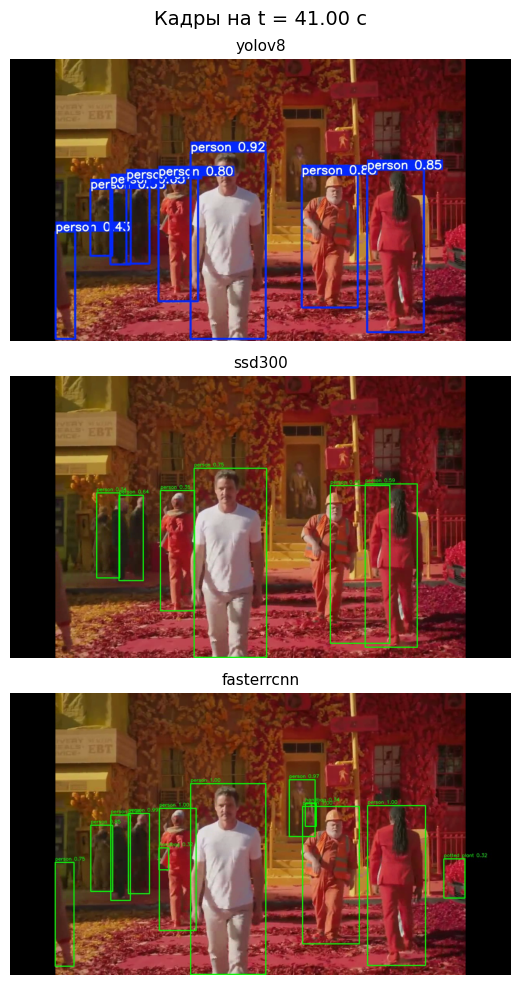

In [33]:
VIDEOS_1 = [
    Path("/content/data/result/yolov8/changeable_conditions.mp4"),
    Path("/content/data/result/ssd300/changeable_conditions.mp4"),
    Path("/content/data/result/fasterrcnn/changeable_conditions.mp4"),
]

show_frames_at_time(VIDEOS_1, time_sec=41.0, cols=1, figsize=(16, 10))


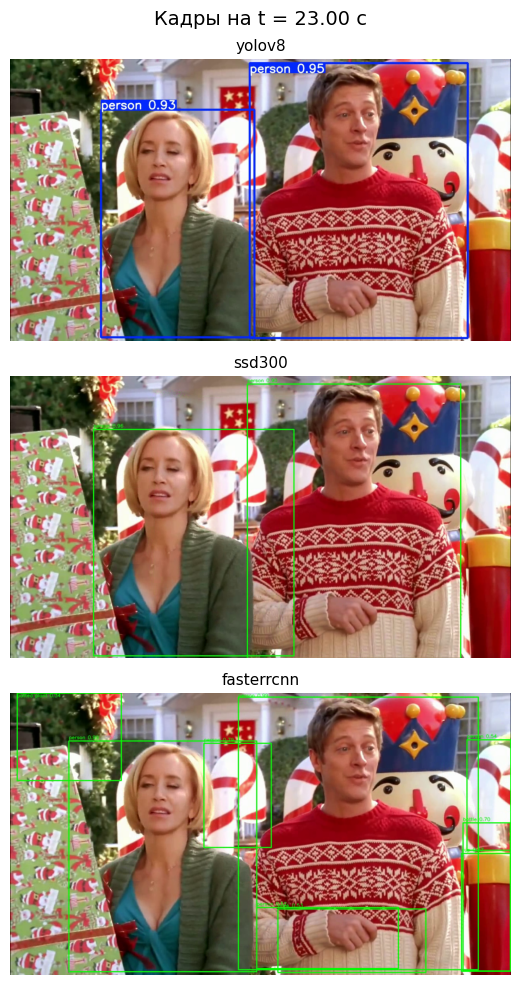

In [34]:
VIDEOS_2 = [
    Path("/content/data/result/yolov8/clear_weather.mp4"),
    Path("/content/data/result/ssd300/clear_weather.mp4"),
    Path("/content/data/result/fasterrcnn/clear_weather.mp4"),
]

show_frames_at_time(VIDEOS_2, time_sec=23.0, cols=1, figsize=(16, 10))


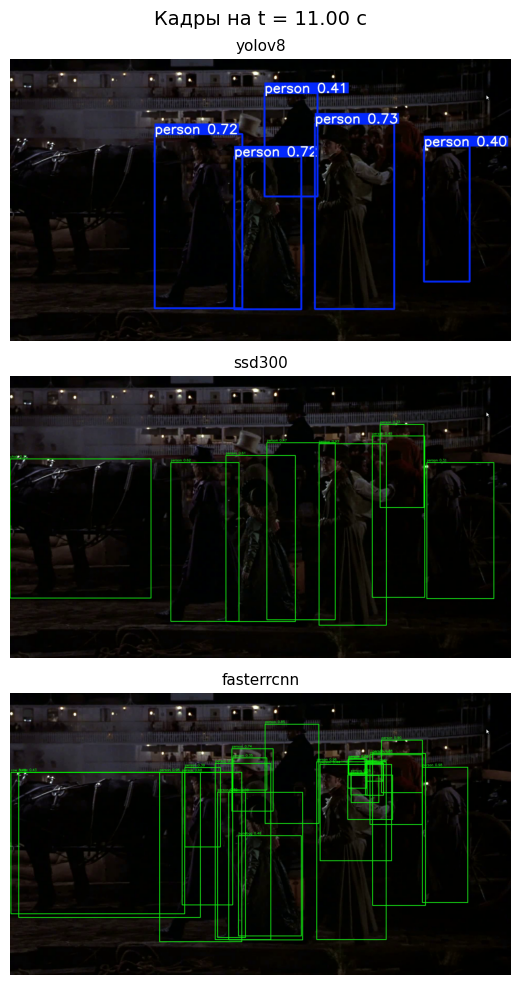

In [36]:
VIDEOS_3 = [
    Path("/content/data/result/yolov8/dark_video.mp4"),
    Path("/content/data/result/ssd300/dark_video.mp4"),
    Path("/content/data/result/fasterrcnn/dark_video.mp4"),
]

show_frames_at_time(VIDEOS_3, time_sec=11.0, cols=1, figsize=(16, 10))


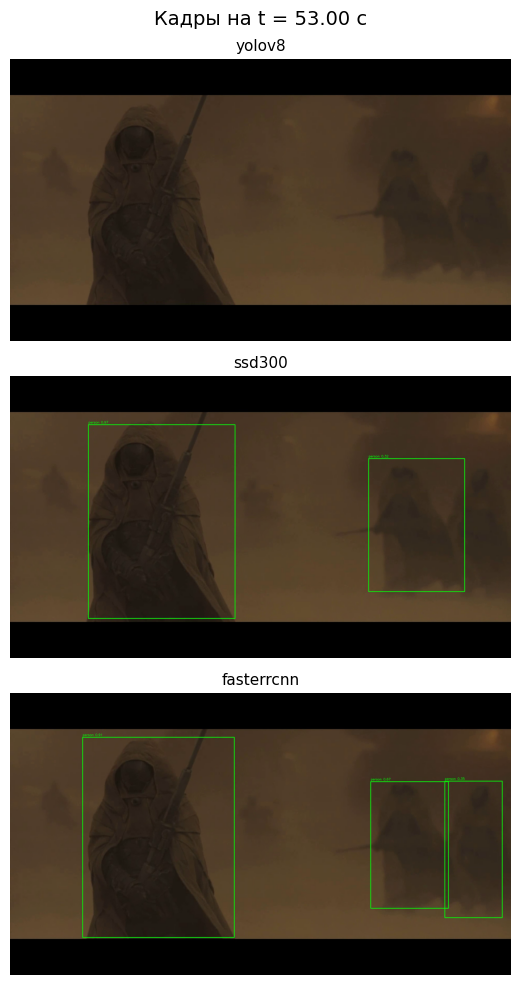

In [44]:
VIDEOS_4 = [
    Path("/content/data/result/yolov8/poor_weather.mp4"),
    Path("/content/data/result/ssd300/poor_weather.mp4"),
    Path("/content/data/result/fasterrcnn/poor_weather.mp4"),
]

show_frames_at_time(VIDEOS_4, time_sec=53, cols=1, figsize=(16, 10))


1. **Скорость работы (avg_fps).** YOLOv8n стабильно самая быстрая (в среднем ~40 FPS, т.е. почти реальное время).
SSD300 примерно в 2–4 раза медленнее, а Faster R-CNN — в 6–8 раз.

2. **Количество детекций людей.** Faster R-CNN даёт наибольшее количество срабатываний — он очень чувствительный, особенно на тёмных сценах (например, 26 тыс. детекций против 7 тыс. у YOLO).
Это говорит о высокой полноте, но возможных ложных срабатываниях (особенно при слабом освещении).

3. **Средняя уверенность модели (avg_confidence)**. Faster R-CNN даёт самые высокие confidence-оценки, даже в сложных условиях (тёмных или плохая погода).
YOLOv8n и SSD немного ниже, особенно в ночных видео (0.57–0.65).

4. **Среднее количество людей на кадр.** Faster R-CNN в сложных условиях даёт более точные прогнозы, чем две остальные модели. Оданко, иногда некорректно отображает людей даже в хороших условиях (можно посмотреть кадры со 2 видео).

5. Максимум людей на одном кадре. На тёмном видео Faster R-CNN лучше всех нашёл людей, поэтому и максимальное число их у него в разы больше.


***Краткий вывод***

**YOLOv8n** — лучшая модель для практического использования:
очень быстрая, стабильная, с умеренной точностью и без переизбытка ложных объектов.

**SSD300** — медленнее и менее уверенная, не много объектов определяет.

**Faster R-CNN** — мощный детектор с высокой уверенностью,
но очень медленный и склонен к “передетекциям”.